# MNIST Classification Example Using NPDL Library

## Importing Libraries

In [1]:
# General Imports
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
# Local Imports
from npdl.nn.activations import ReLU, Softmax
from npdl.nn.losses import CCELoss
from npdl.nn.optimizers import Adam
from npdl.nn.layers import Linear, Conv2D, \
    Dropout, BatchNorm1D, BatchNorm2D, MaxPool2D, Flatten
from npdl.nn.models import Sequential
from npdl.datasets import mnist

## Loading MNIST data

In [2]:
X_train, y_train, X_test, y_test = mnist.load_data('./data', download = False)

# Using Full Connected Layers Only

## Data Preprocessing

In [3]:
X_train = X_train.reshape(-1, 28 * 28).astype('float64') # Reshaping data to (N, k) for Linear layers
X_test = X_test.reshape(-1, 28 * 28).astype('float64')
y_train = np.eye(10)[y_train].reshape(-1, 10) # One hot encoding the target values
y_test = np.eye(10)[y_test].reshape(-1, 10)

# Normalizing pixel data between 0 and 1
X_train /= 255.
X_test /= 255.

In [4]:
# Function that makes batches given training/testing data and labels
def make_batches(X, y, batch_size):
    assert X.shape[0] == y.shape[0]
    
    n_examples = X.shape[0]
    n_batches = n_examples // batch_size
    
    if n_batches * batch_size < n_examples:
        n_batches += 1
    
    resX, resY = [], []
    for batch in range(n_batches):
        batch_X = X[batch * batch_size :(batch+1) * batch_size]
        batch_y = y[batch * batch_size : (batch+1) * batch_size]
        
        resX.append(batch_X)
        resY.append(batch_y)
    
    return resX, resY

In [5]:
BATCH_SIZE = 32
batchesX_train, batchesY_train = make_batches(X_train, y_train, batch_size = BATCH_SIZE)
batchesX_test, batchesY_test = make_batches(X_test, y_test, batch_size = BATCH_SIZE)

## Model Development and Training

In [6]:
epochs = 8
loss_fn = CCELoss()
optim_fn = Adam(lr = 1e-3)

model = Sequential()

model.add(Linear(784, 64, init = 'he_uniform'))
model.add(BatchNorm1D(64))
model.add(ReLU())

model.add(Linear(64, 64, init = 'he_uniform'))
model.add(BatchNorm1D(64))
model.add(ReLU())

model.add(Linear(64, 10))
model.add(Softmax())

model.finalize(loss = loss_fn, optimizer = optim_fn)

In [9]:
# Training function
def train(model, loss_fn, optim_fn, n_epochs, batchesX_train, batchesY_train, batchesX_test, batchesY_test):
    # Keeping track of training/validation metrics
    training_losses = []
    validation_losses = []
    training_accuracies = []
    validation_accuracies = []
    epochs = []
    
    for epoch in tqdm(range(1, n_epochs + 1)):
        # Cumulative metrics during training
        train_loss_accum = 0
        train_acc_accum = 0
        val_loss_accum = 0
        val_acc_accum = 0
        for i in range(len(batchesX_train)):
            batch_x = batchesX_train[i] # Current batch inputs
            batch_y = batchesY_train[i] # Current batch targets

            y_pred = model.forward(batch_x, training = True) # Forward pass of model, returns predictions
            loss, _ = loss_fn.calculate(y_pred, batch_y) # Loss calculation
            acc = np.sum(np.argmax(y_pred, axis = 1) == \
                             np.argmax(batch_y, axis = 1)) / BATCH_SIZE # Accuracy calculation

            train_loss_accum += loss
            train_acc_accum += acc


            model.backward(y_pred, batch_y) # Backwards Pass (gradient calculation)
            model.update_params() # Optimizer updates

        for i in range(len(batchesX_test)): # Validation forward pass and metric calculation
            batch_x = batchesX_test[i]
            batch_y = batchesY_test[i]

            y_pred = model.forward(batch_x, training = False)
            loss, _ = loss_fn.calculate(y_pred, batch_y)
            acc = np.sum(np.argmax(y_pred, axis = 1) == np.argmax(batch_y, axis = 1)) / BATCH_SIZE

            val_loss_accum += loss
            val_acc_accum += acc


        train_batch_loss = train_loss_accum / len(batchesX_train)
        train_batch_acc = train_acc_accum / len(batchesX_train)
        val_batch_loss = val_loss_accum / len(batchesX_test)
        val_batch_acc = val_acc_accum / len(batchesX_test)

        training_losses.append(train_batch_loss)
        training_accuracies.append(train_batch_acc)
        validation_losses.append(val_batch_loss)
        validation_accuracies.append(val_batch_acc)
        epochs.append(epoch)
        
        print("Epoch [%s/%s]" % (str(epoch), str(n_epochs)))
        print("Training Loss: %s" % str(train_batch_loss))
        print("Training Accuracy: %s" % str(train_batch_acc))
        print("Validation Loss: %s" % str(val_batch_loss))
        print("Validation Accuracy: %s" % str(val_batch_acc))
        print()
        
    
    
    return np.array(epochs), np.array(training_losses), np.array(validation_losses), \
        np.array(training_accuracies), np.array(validation_accuracies)

epochs, training_losses, validation_losses, training_accuracies, validation_accuracies = \
    train(model, loss_fn, optim_fn, epochs, batchesX_train, batchesY_train, batchesX_test, batchesY_test)

 12%|█████▋                                       | 1/8 [00:04<00:29,  4.23s/it]

Epoch [1]/[8]
Training Loss: 0.13569934921764962
Training Accuracy: 0.9586666666666667
Validation Loss: 0.11169309520267971
Validation Accuracy: 0.9627595846645367



 25%|███████████▎                                 | 2/8 [00:08<00:25,  4.24s/it]

Epoch [2]/[8]
Training Loss: 0.09628545131003516
Training Accuracy: 0.9710666666666666
Validation Loss: 0.10510962293363792
Validation Accuracy: 0.9646565495207667



 38%|████████████████▉                            | 3/8 [00:12<00:21,  4.27s/it]

Epoch [3]/[8]
Training Loss: 0.07194006197944881
Training Accuracy: 0.9790833333333333
Validation Loss: 0.10115484986972709
Validation Accuracy: 0.9673522364217252



 50%|██████████████████████▌                      | 4/8 [00:17<00:17,  4.26s/it]

Epoch [4]/[8]
Training Loss: 0.056003416132065144
Training Accuracy: 0.9838833333333333
Validation Loss: 0.10537255440833716
Validation Accuracy: 0.9661541533546326



 62%|████████████████████████████▏                | 5/8 [00:21<00:12,  4.26s/it]

Epoch [5]/[8]
Training Loss: 0.0428855519648912
Training Accuracy: 0.9879
Validation Loss: 0.10579690793812911
Validation Accuracy: 0.9678514376996805



 75%|█████████████████████████████████▊           | 6/8 [00:25<00:08,  4.27s/it]

Epoch [6]/[8]
Training Loss: 0.03448367773533364
Training Accuracy: 0.9902333333333333
Validation Loss: 0.10658935904594713
Validation Accuracy: 0.9685503194888179



 88%|███████████████████████████████████████▍     | 7/8 [00:29<00:04,  4.28s/it]

Epoch [7]/[8]
Training Loss: 0.028530420824296958
Training Accuracy: 0.9918333333333333
Validation Loss: 0.10924012106852903
Validation Accuracy: 0.9709464856230032



100%|█████████████████████████████████████████████| 8/8 [00:34<00:00,  4.28s/it]

Epoch [8]/[8]
Training Loss: 0.025374716847279613
Training Accuracy: 0.9916666666666667
Validation Loss: 0.10720823328211312
Validation Accuracy: 0.9716453674121406



## Model Prediction and Evaluation

4


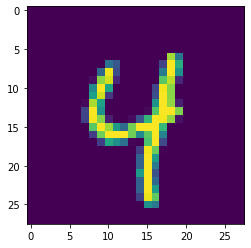

In [10]:
def predict(i):
    img = X_test[i].reshape(28, 28)
    plt.imshow(img)
    y = model.forward(img.reshape(1, 784), training = False)
    print(np.argmax(y))

seed = random.randint(0, 10000)
predict(seed)

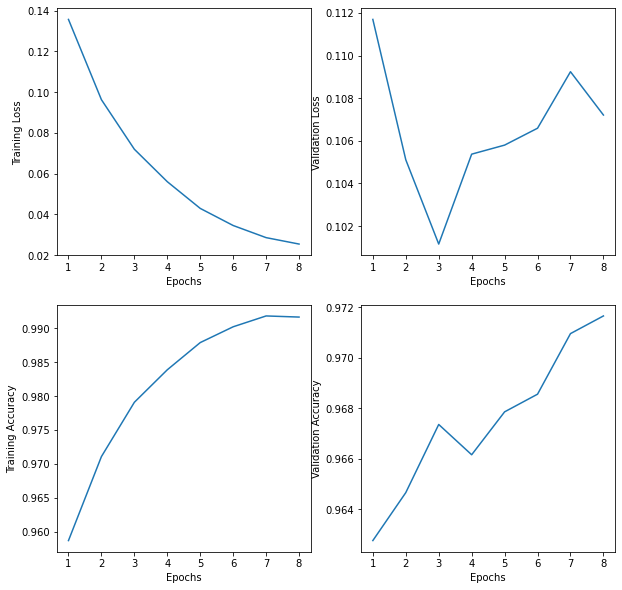

In [12]:
def plot_metrics(training_losses, validation_losses, training_accuracies, validation_accuracies):
    fig, ax = plt.subplots(2, 2)
    fig.set_figheight(10)
    fig.set_figwidth(10)

    ax[0][0].plot(epochs, training_losses)
    ax[0][0].set(xlabel = 'Epochs', ylabel = 'Training Loss')

    ax[0][1].plot(epochs, validation_losses)
    ax[0][1].set(xlabel = "Epochs", ylabel = "Validation Loss")

    ax[1][0].plot(epochs, training_accuracies)
    ax[1][0].set(xlabel = "Epochs", ylabel = "Training Accuracy")

    ax[1][1].plot(epochs, validation_accuracies)
    ax[1][1].set(xlabel = "Epochs", ylabel = "Validation Accuracy")

plot_metrics(training_losses, validation_losses, training_accuracies, validation_accuracies)

# Using Convolutional Layers

## Data Preprocessing

In [13]:
X_train, y_train, X_test, y_test = mnist.load_data('./data', download = False)

n_examples = 10000
X_train = X_train[:n_examples].reshape(-1, 1, 28, 28).astype('float64')
X_test = X_test[:n_examples].reshape(-1, 1, 28, 28).astype('float64')
y_train = np.eye(10)[y_train[:n_examples]].reshape(-1, 10)
y_test = np.eye(10)[y_test[:n_examples]].reshape(-1, 10)

X_train /= 255.
X_test /= 255.

In [14]:
BATCH_SIZE = 32
batchesX_train, batchesY_train = make_batches(X_train, y_train, batch_size = BATCH_SIZE)
batchesX_test, batchesY_test = make_batches(X_test, y_test, batch_size = BATCH_SIZE)

## Model Development and Training

In [15]:
epochs = 5
loss_fn = CCELoss()
optim_fn = Adam(lr = 1e-3)

model = Sequential()

model.add(Conv2D(1, 16, (3, 3), padding = (0, 0), stride = (1, 1), init = 'he_normal'))
model.add(MaxPool2D(pool_size = (2, 2), stride = (2, 2)))
model.add(BatchNorm2D(16))
model.add(ReLU())
model.add(Dropout(0.1))

model.add(Conv2D(16, 64, (3, 3), padding = (0, 0), stride = (1, 1), init = 'he_normal'))
model.add(MaxPool2D(pool_size = (2, 2), stride = (2, 2)))
model.add(BatchNorm2D(64))
model.add(ReLU())
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Linear(64 * 5 * 5, 64, init = 'he_normal'))
model.add(BatchNorm1D(64))
model.add(ReLU())
model.add(Dropout(0.1))

model.add(Linear(64, 64, init = 'he_normal'))
model.add(BatchNorm1D(64))
model.add(ReLU())
model.add(Dropout(0.1))

model.add(Linear(64, 10, init = 'xavier_normal'))
model.add(Softmax())

model.finalize(loss = loss_fn, optimizer = optim_fn)

In [16]:
epochs, training_losses, validation_losses, training_accuracies, validation_accuracies = \
    train(model, loss_fn, optim_fn, epochs, batchesX_train, batchesY_train, batchesX_test, batchesY_test)

 20%|█████████                                    | 1/5 [00:43<02:54, 43.50s/it]

Epoch [1]/[5]
Training Loss: 0.5813174341348133
Training Accuracy: 0.8441493610223643
Validation Loss: 0.16905519155608156
Validation Accuracy: 0.9528753993610224



 40%|██████████████████                           | 2/5 [01:28<02:13, 44.57s/it]

Epoch [2]/[5]
Training Loss: 0.2270479710796998
Training Accuracy: 0.93560303514377
Validation Loss: 0.12229777803232522
Validation Accuracy: 0.9617611821086262



 60%|███████████████████████████                  | 3/5 [02:16<01:31, 45.78s/it]

Epoch [3]/[5]
Training Loss: 0.19670235756359788
Training Accuracy: 0.9395966453674122
Validation Loss: 0.1417613130879511
Validation Accuracy: 0.9549720447284346



 80%|████████████████████████████████████         | 4/5 [03:03<00:46, 46.38s/it]

Epoch [4]/[5]
Training Loss: 0.20373580705690167
Training Accuracy: 0.9366014376996805
Validation Loss: 0.17756106270253502
Validation Accuracy: 0.9404952076677316



100%|█████████████████████████████████████████████| 5/5 [03:50<00:00, 46.15s/it]

Epoch [5]/[5]
Training Loss: 0.24534096971650585
Training Accuracy: 0.9207268370607029
Validation Loss: 0.17273411200431923
Validation Accuracy: 0.9459864217252396



## Model Prediction

9


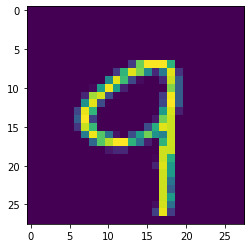

In [17]:
def predict(i):
    img = X_test[i].reshape(28, 28)
    plt.imshow(img)
    y = model.forward(img.reshape(1, 1, 28, 28), training = False)
    print(np.argmax(y))

seed = random.randint(0, n_examples - 1)
predict(seed)

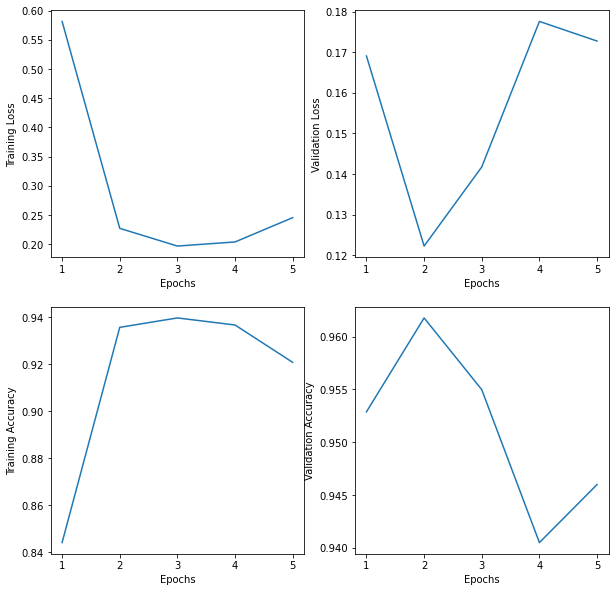

In [18]:
plot_metrics(training_losses, validation_losses, training_accuracies, validation_accuracies)